In [1]:
# torch downgrade for deployment of face recog
!pip install torch==1.5.0 torchvision==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 603.7MB 28kB/s 
     |████████████████████████████████| 6.5MB 664kB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [2]:
# reference: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
! nvidia-smi

Sun Sep 20 17:46:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
%matplotlib inline

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import sys
S7_PROJECT_PATH = '/content/drive/My Drive/TSAI/TSAI-2/S7/Save_Model/'

In [17]:
!7z x '/content/drive/My Drive/TSAI/TSAI-2/S7/Save_Model/CARS.7z' -o'/content/' -ir!'CARS/RED/*.jpg'


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/My Drive/TSAI/TSAI-2/S7/Save_Model/                                                            1 file, 65563587 bytes (63 MiB)

Extracting archive: /content/drive/My Drive/TSAI/TSAI-2/S7/Save_Model/CARS.7z
--
Path = /content/drive/My Drive/TSAI/TSAI-2/S7/Save_Model/CARS.7z
Type = 7z
Physical Size = 65563587
Headers Size = 38769
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      8%     20% 75 . CARS/LEFT/22.jpg                           29% 148 . CARS/LEFT/7.jpg                           42% 271 . CAR

In [18]:
from __future__ import print_function
# %matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.nn import functional as F

from pathlib import Path
from torchsummary import summary

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [19]:
# Root directory for dataset
dataroot = "/content/CARS"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 144

# number of channels
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Number of training epochs
num_epochs = 1000
# Learning rate for optimizers
lr = 0.005

# Beta1 hyperparam for Adam optimizers
beta1 = 0.95

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# image size after transformation
image_size=128

Data
----


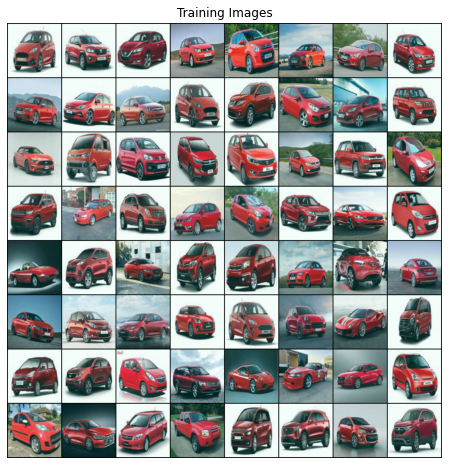

In [20]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.570838093757629, 0.479552984237671, 0.491760671138763), (0.279659748077393, 0.309973508119583, 0.311098515987396))
                           ]))

# creating trainset and testset
trainset,testset = torch.utils.data.random_split(dataset, [int(.95*len(dataset))+1, int(.05*len(dataset))]) 

# Create the dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(trainloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Variational Auto Encoder



In [21]:
from typing import List, Callable, Union, Any, TypeVar, Tuple
Tensor = TypeVar('torch.tensor')
class VAE(nn.Module):
    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(VAE, self).__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*16, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*16, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 16)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 4, 4)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':-kld_loss}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

Now, as with the generator, we can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.




In [22]:
vae = VAE(in_channels=nc, latent_dim=nz, hidden_dims=[32,64,128,256,512])

# Create the Discriminator
vae = vae.to(device)

In [23]:
summary(vae, input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
       BatchNorm2d-2           [-1, 32, 64, 64]              64
         LeakyReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
       BatchNorm2d-5           [-1, 64, 32, 32]             128
         LeakyReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
       BatchNorm2d-8          [-1, 128, 16, 16]             256
         LeakyReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10            [-1, 256, 8, 8]         295,168
      BatchNorm2d-11            [-1, 256, 8, 8]             512
        LeakyReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 512, 4, 4]       1,180,160
      BatchNorm2d-14            [-1, 51

Loss Functions and Optimizers

In [24]:
# optimizer
optimizer = optim.Adam(vae.parameters(), lr=lr, betas=(beta1, 0.999))

In [25]:
!mkdir results
!mkdir samples
!mkdir checkpoints

In [26]:
trainloss=[]
testloss=[]
img_list=[]
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        loss = vae.loss_function(*vae(data), M_N=batch_size/len(trainset))
        loss['loss'].backward()
        train_loss += loss['loss'].item()
        optimizer.step()
        if batch_idx % 4 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tRecLoss: {:.6f}\tKLDLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader),
                loss['loss'].item() / len(data), loss['Reconstruction_Loss'].item()/len(data), loss['KLD'].item()/len(data)))
    trainloss.append(train_loss / len(trainloader.dataset))
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(trainloader.dataset)))

def test(epoch):
    vae.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(testloader):
            data = data.to(device)
            results = vae(data)
            test_loss += vae.loss_function(*results, M_N=batch_size/len(testset))['loss'].item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([results[1][:n],
                                      results[0][:n]])
                img_list.append(vutils.make_grid(comparison.cpu(), padding=2, normalize=True))
                vutils.save_image(comparison.cpu(),
                         'results/reconstruction_' + f'{epoch:04}' + '.jpg', nrow=n, normalize=True)
    test_loss /= len(testloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    testloss.append(test_loss)

In [27]:
for epoch in range(1, num_epochs+1):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = vae.sample(num_samples=64, current_device=device).cpu()
            vutils.save_image(sample,
                       'samples/sample_' + f'{epoch:04}' + '.jpg', normalize=True)

Train Epoch: 1 [0/1390 (0%)]	Loss: 0.017965	RecLoss: 0.008988	KLDLoss: -0.086648
Train Epoch: 1 [576/1390 (40%)]	Loss: 77.537896	RecLoss: 0.008644	KLDLoss: -748.372613
Train Epoch: 1 [1152/1390 (80%)]	Loss: 3902.152344	RecLoss: 0.008360	KLDLoss: -37666.531250
====> Epoch: 1 Average loss: 6931453.0920
====> Test set loss: 407423435715114687344863608832.0000
Train Epoch: 2 [0/1390 (0%)]	Loss: 15839.876736	RecLoss: 0.008462	KLDLoss: -152898.736111
Train Epoch: 2 [576/1390 (40%)]	Loss: 27.297401	RecLoss: 0.008470	KLDLoss: -263.413981
Train Epoch: 2 [1152/1390 (80%)]	Loss: 2.174489	RecLoss: 0.008084	KLDLoss: -20.911819
====> Epoch: 2 Average loss: 18095.5384
====> Test set loss: 312993396290845376.0000
Train Epoch: 3 [0/1390 (0%)]	Loss: 17.876070	RecLoss: 0.007722	KLDLoss: -172.479194
Train Epoch: 3 [576/1390 (40%)]	Loss: 8.026303	RecLoss: 0.008190	KLDLoss: -77.397061
Train Epoch: 3 [1152/1390 (80%)]	Loss: 6.379043	RecLoss: 0.007820	KLDLoss: -61.500000
====> Epoch: 3 Average loss: 35.8775
=

KeyboardInterrupt: ignored

In [28]:
!7z a '{S7_PROJECT_PATH}results.7z' '/content/results/'
!7z a '{S7_PROJECT_PATH}samples.7z' '/content/samples/'


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive:
  0M Scan  /content/                    1 folder, 309 files, 13028066 bytes (13 MiB)

Creating archive: /content/drive/My Drive/TSAI/TSAI-2/S7/Save_Model/results.7z

Items to compress: 310

  0%      6% 38 + results/reconstruction_0039.jpg                                          14% 61 + results/reconstruction_0062.jpg                                          23% 85 + results/reconstruction_0086.jpg                                          30% 108 + results/reconstruction_0109.jpg

Results


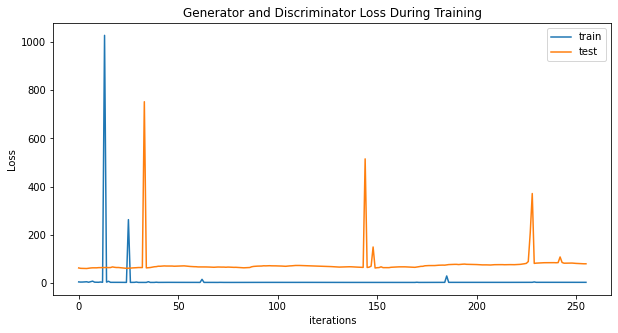

In [34]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(trainloss[10:266],label="train")
plt.plot(testloss[10:266],label="test")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

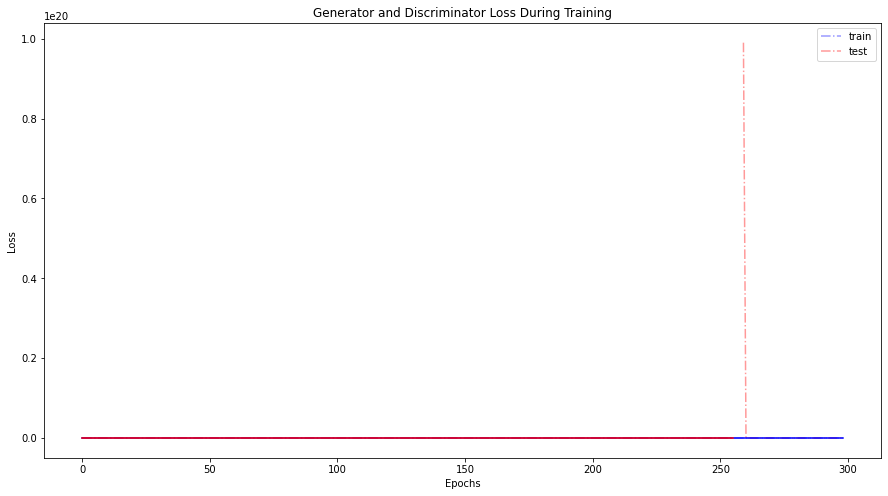

In [30]:
def smooth_curv(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return np.array(smoothed)

plt.figure(figsize=(15, 8))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(trainloss[10:], 'b-.',label="train", alpha=0.4)
plt.plot(testloss[10:], 'r-.', label="test", alpha=0.4)
plt.plot(smooth_curv(trainloss[10:], 0.95), 'b')
plt.plot(smooth_curv(testloss[10:], 0.95), 'r')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.




In [31]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.




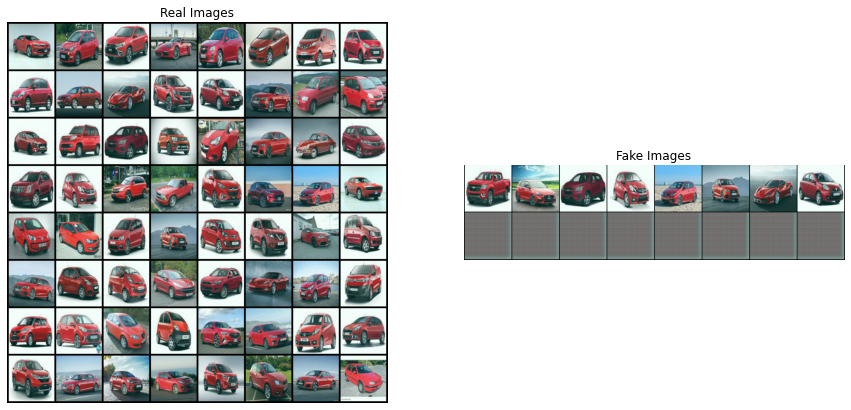

In [32]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(testloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# Save the Model

In [33]:
torch.save(vae, f'{S7_PROJECT_PATH}red_car_gan_generator.pt')
traced_model = torch.jit.trace(vae.to('cpu'), torch.randn(1, 3, 128, 128))
traced_model.save(f'{S7_PROJECT_PATH}red_car_gan_generator.traced.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
# !rm -r CARS
# !rm -r results
# !rm -r samples

In [ ]:
# drive.flush_and_unmount()